# Exploratory Data Analysis (EDA) - Leukemia Cancer Risk Prediction Dataset
# Written by: Valentina Bueno, Natalia Moreno and Esmeralda Erazo. Data Engineer and IA. 

This document outlines the steps taken to perform an EDA on the leukemia-cancer-risk-prediction-dataset. The dataset contains 143,194 rows and 22 columns, including patient demographics, medical history, and laboratory results.

We need the followings libraries.

In [8]:
import json
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ks_1samp
from scipy.stats import chi2_contingency
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import kruskal
import math
import sqlalchemy 
from sqlalchemy import create_engine

#### Step 1: Load the Dataset from the Database
First, we need to load the dataset from the database. Below is the code to connect to the database and retrieve the data.

In [9]:
with open("credentials.json") as f:
    credentials = json.load(f)

db_host = credentials["host"]
db_name = credentials["dbname"]
db_user = credentials["user"]
db_password = credentials["password"]
db_port = credentials["port"]  

conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port  )

In [17]:
query = "SELECT * FROM Leukemia_raw_data;"
df = pd.read_sql(query, conn)

print(df.head())

C:\Users\memer\AppData\Local\Temp\ipykernel_29148\983436045.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


   patient_id  age  gender country  wbc_count  rbc_count  platelet_count  \
0           1   52    Male   China       2698       5.36          262493   
1           2   15  Female   China       4857       4.81          277877   
2           3   72    Male  France       9614       5.17          319600   
3           4   61    Male  Brazil       6278       5.41          215200   
4           5   21    Male  Brazil       8342       4.78          309169   

   hemoglobin_level  bone_marrow_blasts genetic_mutation  ...  \
0              12.2                  72              Yes  ...   
1              11.9                  97              Yes  ...   
2              13.4                  94               No  ...   
3              11.6                  50               No  ...   
4              14.3                  28               No  ...   

  alcohol_consumption radiation_exposure infection_history   bmi  \
0                  No                 No                No  24.0   
1               

#### Step 2: Initial Data Inspection
After loading the dataset, we perform an initial inspection to understand its structure and identify any immediate issues.

*df.shape* returns the number of rows and columns in the dataset. <br>
*df.dtypes* provides the data type of each column <br>
*df.isnull().sum()*  counts the number of missing values in each column. <br>


In [18]:
print(f"Dataset Shape: {df.shape}")
print("\nMissing Values per Column:")
print(df.isnull().sum())

Dataset Shape: (143194, 22)

Missing Values per Column:
patient_id              0
age                     0
gender                  0
country                 0
wbc_count               0
rbc_count               0
platelet_count          0
hemoglobin_level        0
bone_marrow_blasts      0
genetic_mutation        0
family_history          0
smoking_status          0
alcohol_consumption     0
radiation_exposure      0
infection_history       0
bmi                     0
chronic_illness         0
immune_disorders        0
ethnicity               0
socioeconomic_status    0
urban_rural             0
leukemia_status         0
dtype: int64


*df.describe()* provides summary statistics (e.g., mean, std, min, max) for numerical columns. <br>
*df.describe(include='object')* provides summary statistics (e.g., count, unique, top, frequency) for categorical columns. <br>

In [19]:
print("\nSummary Statistics for Numerical Columns:")
print(df.describe())
print("\nSummary Statistics for Categorical Columns:")
print(df.describe(include='object'))


Summary Statistics for Numerical Columns:
         patient_id            age      wbc_count      rbc_count  \
count  143194.00000  143194.000000  143194.000000  143194.000000   
mean    71597.50000      44.945200    7001.289879       4.998193   
std     41336.69156      25.737805    2007.444410       0.500298   
min         1.00000       1.000000   -1602.000000       2.940000   
25%     35799.25000      23.000000    5644.250000       4.660000   
50%     71597.50000      45.000000    7007.000000       5.000000   
75%    107395.75000      67.000000    8352.000000       5.340000   
max    143194.00000      89.000000   15586.000000       7.150000   

       platelet_count  hemoglobin_level  bone_marrow_blasts            bmi  
count   143194.000000     143194.000000       143194.000000  143194.000000  
mean    249933.012137         13.498334           49.547984      24.990679  
std      49842.308243          1.996714           28.837607       4.999786  
min      46069.000000          4.700

Check for duplicates

In [42]:
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 0


Rename Columns <br>
To make the dataset easier to work with, we will rename the columns to have Consistency,Readability and Efficiency.

In [43]:
column_rename_dict = {
    "patient_id": "id", 
    "age": "age",
    "gender": "gender",
    "country": "country",
    "ethnicity": "ethnicity",
    "socioeconomic_status": "socioeconomic_status",
    "urban_rural": "urban_rural",
    "family_history": "family_history",
    "smoking_status": "smoking_status",
    "alcohol_consumption": "alcohol_consumption",
    "radiation_exposure": "radiation_exposure",
    "infection_history": "infection_history",
    "chronic_illness": "chronic_illness",
    "immune_disorders": "immune_disorders",
    "wbc_countsort": "wbc_count",
    "rbc_countsort": "rbc_count",
    "platelet_countsort": "platelet_count",
    "hemoglobin_level": "hemoglobin",
    "bone_marrow_blasts": "bone_marrow_blasts",
    "genetic_mutation": "genetic_mutation",
    "leukemia_status": "leukemia_status"
}
df.rename(columns=column_rename_dict, inplace=True)
print("Updated Column Names:")
print(df.columns.tolist())

Updated Column Names:
['id', 'age', 'gender', 'wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bone_marrow_blasts', 'genetic_mutation', 'family_history', 'smoking_status', 'alcohol_consumption', 'radiation_exposure', 'infection_history', 'bmi', 'chronic_illness', 'immune_disorders', 'socioeconomic_status', 'urban_rural', 'leukemia_status', 'continent']


In [44]:
df.head()

,id,age,gender,wbc_count,rbc_count,platelet_count,hemoglobin,bone_marrow_blasts,genetic_mutation,family_history,...,alcohol_consumption,radiation_exposure,infection_history,bmi,chronic_illness,immune_disorders,socioeconomic_status,urban_rural,leukemia_status,continent
0,1,52,Male,2698,5.36,262493,12.2,72,Yes,No,...,No,No,No,24.0,No,No,Low,Rural,Negative,Asia
1,2,15,Female,4857,4.81,277877,11.9,97,Yes,No,...,No,No,No,28.7,No,No,Low,Urban,Positive,Asia
2,3,72,Male,9614,5.17,319600,13.4,94,No,Yes,...,Yes,No,No,27.7,No,No,Low,Urban,Negative,Europe
3,4,61,Male,6278,5.41,215200,11.6,50,No,No,...,No,No,No,31.6,No,No,Medium,Rural,Negative,South America
4,5,21,Male,8342,4.78,309169,14.3,28,No,No,...,No,No,No,22.3,No,No,Low,Rural,Negative,South America


#### Step 3: Detecting Anomalies in a Dataset

This script identifies negative values in specific numerical columns that should only contain positive values. It counts occurrences per column and lists the affected patient IDs for further review. If negative values are found, they can be corrected or removed to ensure data integrity.


In [45]:
num_cols = ['wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bmi']

negativos_dict = {}

for col in num_cols:
    negativos_dict[col] = (df[col] < 0).sum()

print("Conteo de valores negativos por variable:")
for col, count in negativos_dict.items():
    if count > 0:
        print(f"{col}: {count} valores negativos")

df_negativos = df[df[num_cols].lt(0).any(axis=1)] 
if not df_negativos.empty:
    print("\nPacientes con valores negativos en alguna columna:")
    print(df_negativos[['id'] + num_cols]) 
else:
    print("\nNo se encontraron valores negativos en las variables seleccionadas.")


Conteo de valores negativos por variable:
wbc_count: 23 valores negativos

Pacientes con valores negativos en alguna columna:
            id  wbc_count  rbc_count  platelet_count  hemoglobin   bmi
7579      7580       -492       5.21          254191        14.5  29.9
16642    16643      -1602       5.56          286509        12.3  22.7
23335    23336        -96       4.92          258472        12.2  20.2
27593    27594       -453       5.12          234769        14.2  24.0
28880    28881        -83       4.97          162669        11.9  23.3
29429    29430       -242       5.61          307589        14.3  25.9
31428    31429      -1415       5.01          255787        11.7  22.2
35422    35423       -313       5.14          259491        17.7  28.7
65493    65494        -96       5.91          237329        15.8  20.8
73116    73117       -959       5.50          246034        14.8  29.4
76635    76636       -649       4.40          235908        11.9  36.6
78880    78881       -

Correlation Matrix Analysis  <br>

Since negative values were found in *wbc_count*, which is clinically impossible, we aim to determine if this variable has a strong correlation with other blood-related parameters. If a strong relationship exists, we can estimate the missing or incorrect values instead of removing them.  If *wbc_count* strongly correlates with another variable, we can estimate its value instead of discarding the data. If no strong correlation exists, alternative imputation methods or removal may be necessary.  

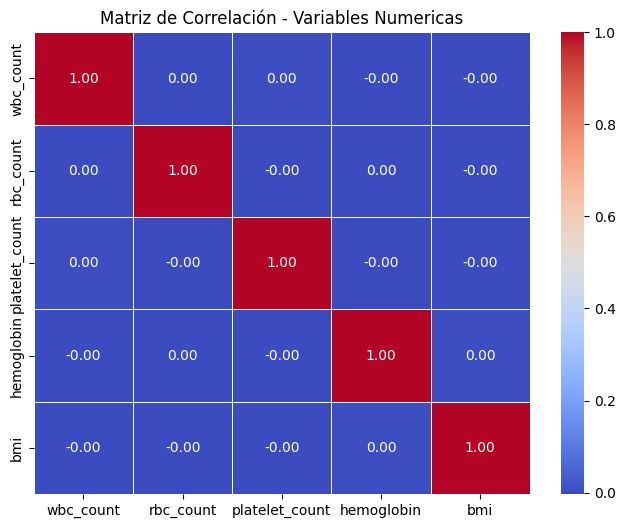

In [46]:
numericvars = ['wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bmi']
correlation_matrix = df[numericvars].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación - Variables Numericas")
plt.show()


After performing a correlation analysis, *wbc_count* showed no significant correlation with other variables (*rbc_count, platelet_count, hemoglobin_level, bmi*).<br> Since negative values in *wbc_count* are biologically impossible and cannot be reliably imputed, we have decided to remove these records.  
All patients with invalid *wbc_count* values will be removed from the dataset to ensure data integrity. The affected patient IDs will be listed in the output.  

In [47]:
invalid_ids = df[df["wbc_count"] < 0]["id"].tolist()

if invalid_ids:
    print(f"Los siguientes pacientes han sido eliminados debido a valores biológicamente inválidos en wbc_count:\n{invalid_ids}")
else:
    print("No se encontraron valores inválidos en wbc_count.")

df = df[df["wbc_count"] >= 0]

Los siguientes pacientes han sido eliminados debido a valores biológicamente inválidos en wbc_count:
[7580, 16643, 23336, 27594, 28881, 29430, 31429, 35423, 65494, 73117, 76636, 78881, 88542, 97654, 100353, 105490, 106354, 116143, 117865, 118978, 119276, 123618, 133168]


To identify potential outliers in the selected variables, the maximum and minimum values of each were calculated.  
This helps establish reference ranges and detect data points that may require correction or removal.  

In [48]:
min_max_values = df[['wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bmi']].agg(['min', 'max'])
print("Valores mínimos y máximos por variable:")
print(min_max_values)

Valores mínimos y máximos por variable:
     wbc_count  rbc_count  platelet_count  hemoglobin   bmi
min         16       2.94           46069         4.7   2.8
max      15586       7.15          460325        22.2  49.1


 A BMI of 2.8 is extremely low and likely represents an error in data entry rather than a real physiological condition, as even individuals with severe malnutrition typically have a BMI above 10. As a next step, values below 10 should be reviewed or removed.

In [49]:
invalid_ids = df[df['bmi'] < 0]['id'].tolist()

df = df[df['bmi'] >= 9]

if invalid_ids:
    print(f"Se eliminaron los siguientes pacientes debido a valores biológicamente inválidos en 'BMI': {invalid_ids}")
else: 
    print("No se encontraron valores inválidos en 'BMI'.")

No se encontraron valores inválidos en 'BMI'.


Categorical variables often contain strings that can become inconsistent due to spelling errors, varying capitalizations, or additional spaces. By extracting the unique values from each categorical column, we can: Identify potential data quality issues (e.g., typos or different formats for the same category),Understand the breadth of categories in the dataset and Decide whether certain values need to be merged or corrected.  

In [50]:
string_cols = df.select_dtypes(include=['object']).columns

for col in string_cols:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}':")
    print(unique_values)
    print("-" * 50)

Unique values in 'gender':
['Male' 'Female']
--------------------------------------------------
Unique values in 'genetic_mutation':
['Yes' 'No']
--------------------------------------------------
Unique values in 'family_history':
['No' 'Yes']
--------------------------------------------------
Unique values in 'smoking_status':
['Yes' 'No']
--------------------------------------------------
Unique values in 'alcohol_consumption':
['No' 'Yes']
--------------------------------------------------
Unique values in 'radiation_exposure':
['No' 'Yes']
--------------------------------------------------
Unique values in 'infection_history':
['No' 'Yes']
--------------------------------------------------
Unique values in 'chronic_illness':
['No' 'Yes']
--------------------------------------------------
Unique values in 'immune_disorders':
['No' 'Yes']
--------------------------------------------------
Unique values in 'socioeconomic_status':
['Low' 'Medium' 'High']
------------------------------

 Working with continents instead of countries reduces complexity while retaining geographic relevance. Helps in grouping data for regional trends. 

In [51]:
country_to_continent = {
    'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'South Korea': 'Asia', 'Saudi Arabia': 'Asia',
    'France': 'Europe', 'Italy': 'Europe', 'Norway': 'Europe', 'Sweden': 'Europe', 'Russia': 'Europe',
    'Netherlands': 'Europe', 'Spain': 'Europe', 'Turkey': 'Europe', 'Germany': 'Europe', 'UK': 'Europe',
    'Brazil': 'South America', 'Argentina': 'South America',
    'USA': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'South Africa': 'Africa',
    'Australia': 'Oceania'
}

df['continent'] = df['country'].map(country_to_continent)

df.drop(columns=['country'], inplace=True)

print("Valores por continente:", df['continent'].unique())

KeyError: 'country'

Simplify Values in the ethnicity Column: We will replace the values in the ethnicity column to make them shorter and more concise.

In [ ]:
ethnicity_mapping = {
    "Ethnic_Group_A": "A",
    "Ethnic_Group_B": "B",
    "Ethnic_Group_C": "C"
}
df["ethnicity"] = df["ethnicity"].replace(ethnicity_mapping)

print("Unique values in 'ethnicity' column after simplification:")
print(df["ethnicity"].unique())

Unique values in 'ethnicity' column after simplification:
['B' 'A' 'C']


#### Step 4: Some statics to make decisions.

To determine whether there are significant differences in numerical variables (`wbc_count`, `rbc_count`, `platelet_count`, `hemoglobin_level`, `bmi`) between patients with and without leukemia (`leukemia_status`), we apply a one-way ANOVA test. This statistical method allows us to compare the mean values of each numerical variable across the two groups: **Positive (Leukemia present)** and **Negative (No leukemia)**. The null hypothesis (**H₀**) assumes no difference in means between the groups, while the alternative hypothesis (**H₁**) suggests a significant difference. If the **p-value < 0.05**, we reject **H₀**, indicating that the variable may be associated with leukemia status. This analysis helps identify potential biomarkers and trends in the dataset, contributing to further clinical insights and predictive modeling. However, it is important to consider assumptions such as normality and equal variances, and to complement ANOVA with visualizations or additional statistical tests if needed.  


ANOVA assumes normality in the data. Before applying it, use a normality test (Kolmogorov-Smirnov)

In [ ]:
numerical_vars = ['wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bmi']
categorical_cols = ['gender', 'continent', 'genetic_mutation', 'family_history', 'smoking_status', 'alcohol_consumption', 'radiation_exposure', 'infection_history', 'chronic_illness', 'immune_disorders', 'ethnicity', 'socioeconomic_status', 'urban_rural', 'leukemia_status']


for col in numerical_vars:

    standardized_data = (df[col] - df[col].mean()) / df[col].std()
    stat, p = ks_1samp(standardized_data, norm.cdf)
    
    print(f"Kolmogorov-Smirnov test for {col}: p-value={p:.5f}")



Kolmogorov-Smirnov test for wbc_count: p-value=0.82696
Kolmogorov-Smirnov test for rbc_count: p-value=0.00336
Kolmogorov-Smirnov test for platelet_count: p-value=0.10992
Kolmogorov-Smirnov test for hemoglobin: p-value=0.00000
Kolmogorov-Smirnov test for bmi: p-value=0.00042


In [ ]:
anovapositive=['wbc_count','platelet_count']
other=[ 'rbc_count', 'hemoglobin', 'bmi']
anova_results = {}
for var in anovapositive:
    group1 = df[df['leukemia_status'] == 'Negative'][var]
    group2 = df[df['leukemia_status'] == 'Positive'][var]
    
    f_stat, p_value = stats.f_oneway(group1, group2)
    anova_results[var] = {'F-statistic': f_stat, 'p-value': p_value}

for var, result in anova_results.items():
    print(f"ANOVA for {var}: F-statistic = {result['F-statistic']:.3f}, p-value = {result['p-value']:.5f}")

kruskal_results = {}
for var in other:
    group1 = df[df['leukemia_status'] == 'Negative'][var]
    group2 = df[df['leukemia_status'] == 'Positive'][var]
    
    h_stat, p_value = kruskal(group1, group2)
    kruskal_results[var] = {'H-statistic': h_stat, 'p-value': p_value}

for var, result in kruskal_results.items():
    print(f"Kruskal-Wallis test for {var}: H-statistic = {result['H-statistic']:.3f}, p-value = {result['p-value']:.5f}")


ANOVA for wbc_count: F-statistic = 0.061, p-value = 0.80466
ANOVA for platelet_count: F-statistic = 0.504, p-value = 0.47796
Kruskal-Wallis test for rbc_count: H-statistic = 0.008, p-value = 0.92695
Kruskal-Wallis test for hemoglobin: H-statistic = 3.077, p-value = 0.07942
Kruskal-Wallis test for bmi: H-statistic = 0.001, p-value = 0.97966



A statistical analysis was conducted using **ANOVA** for normally distributed variables and **Kruskal-Wallis** for non-normally distributed variables to assess potential differences based on leukemia status. The results showed no statistically significant differences in any of the tested variables. Specifically, for the ANOVA tests, *wbc_count* (F-statistic = 0.065, p-value = 0.79912) and *platelet_count* (F-statistic = 0.438, p-value = 0.50817) did not exhibit significant variations between groups. Similarly, the Kruskal-Wallis tests for *rbc_count* (H-statistic = 0.004, p-value = 0.94705), *hemoglobin_level* (H-statistic = 3.152, p-value = 0.07584), and *bmi* (H-statistic = 0.000, p-value = 0.99562) indicated no meaningful statistical differences. Since all p-values exceed **0.05**, there is no evidence to suggest a significant correlation between leukemia status and any of the numerical variables analyzed.  


##### Chi-Square Test for categorical variables vs leukemia status

In [ ]:
chi2_results = {}

for col in categorical_cols:
    if col != 'leukemia_status':
        contingency_table = pd.crosstab(df[col], df['leukemia_status'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi2_results[col] = (chi2, p)
        print(f"Chi-Square Test for {col} vs Leukemia Status: Chi2 = {chi2:.3f}, p-value = {p:.5f}")
    else:
        print("No correlation " 'leukemia_status')

Chi-Square Test for gender vs Leukemia Status: Chi2 = 0.015, p-value = 0.90311
Chi-Square Test for continent vs Leukemia Status: Chi2 = 4.557, p-value = 0.47225
Chi-Square Test for genetic_mutation vs Leukemia Status: Chi2 = 0.035, p-value = 0.85056
Chi-Square Test for family_history vs Leukemia Status: Chi2 = 0.053, p-value = 0.81731
Chi-Square Test for smoking_status vs Leukemia Status: Chi2 = 0.024, p-value = 0.87633
Chi-Square Test for alcohol_consumption vs Leukemia Status: Chi2 = 0.235, p-value = 0.62796
Chi-Square Test for radiation_exposure vs Leukemia Status: Chi2 = 0.068, p-value = 0.79459
Chi-Square Test for infection_history vs Leukemia Status: Chi2 = 1.267, p-value = 0.26033
Chi-Square Test for chronic_illness vs Leukemia Status: Chi2 = 0.000, p-value = 0.99766
Chi-Square Test for immune_disorders vs Leukemia Status: Chi2 = 1.163, p-value = 0.28081
Chi-Square Test for ethnicity vs Leukemia Status: Chi2 = 0.486, p-value = 0.78434
Chi-Square Test for socioeconomic_status vs 

 A Chi-Square test was conducted to evaluate potential associations between categorical variables and leukemia status. The results indicate that none of the tested variables show a statistically significant relationship with leukemia status.All resulted in p-values greater than **0.05**, indicating no statistically significant associations. These findings suggest that none of the examined categorical variables are strongly linked to leukemia status in this dataset.  


#### Step 5: Visualizations to explore the dataset and guide decisions.  
To better understand the dataset and identify patterns, we generate visualizations that highlight the distribution of numerical and categorical variables. For numerical variables (`wbc_count`, `rbc_count`, `platelet_count`, `hemoglobin_level`, `bmi`), we use **histograms** and **kernel density plots (KDE)** to observe their shape and detect skewness or potential outliers. **Boxplots** provide additional insights into variability and extreme values. For categorical variables (`gender`, `continent`, `genetic_mutation`, etc.), we apply **bar charts** to analyze frequency distributions and potential imbalances in the dataset. These initial visualizations allow us to make informed decisions about further data processing and feature selection. Once key insights are derived, we incorporate the most relevant visualizations into a dashboard, including **violin plots** and **stacked bar charts**, to compare leukemia status distributions and explore variable interactions more effectively.


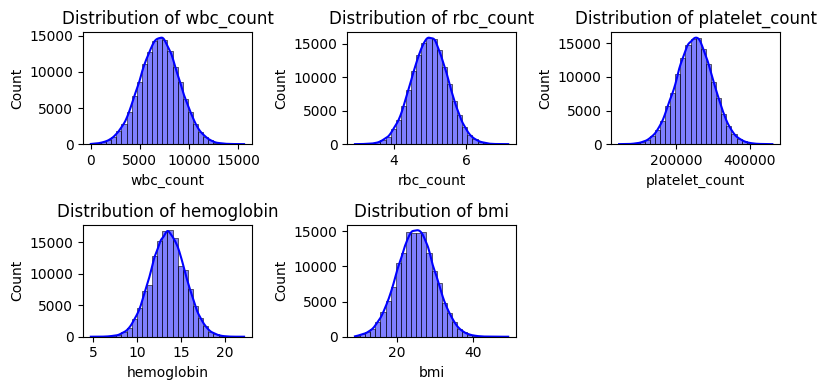

In [ ]:
plt.figure(figsize=(8, 4))  
for i, col in enumerate(numerical_vars, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

The WBC count appears slightly right-skewed, indicating that while most values cluster around the center, some higher values extend the tail to the right. The RBC count and hemoglobin level both exhibit a nearly normal distribution, with well-defined peaks and symmetrical spreads, suggesting that the majority of patients fall within a common physiological range. The platelet count, however, shows a right-skewed distribution, meaning that while most values concentrate around the central peak, there are individuals with significantly higher counts, potentially indicating underlying conditions. Lastly, the BMI distribution is approximately normal, though it exhibits a slight right skew, reflecting the presence of individuals with higher-than-average BMI values.

These distributions help assess normality assumptions, which are critical for statistical testing. While most variables conform to a normal distribution, WBC count and platelet count may require transformations such as log or Box-Cox transformations if normality-based tests are needed. No extreme outliers are immediately visible, but further validation with box plots could provide confirmation. 

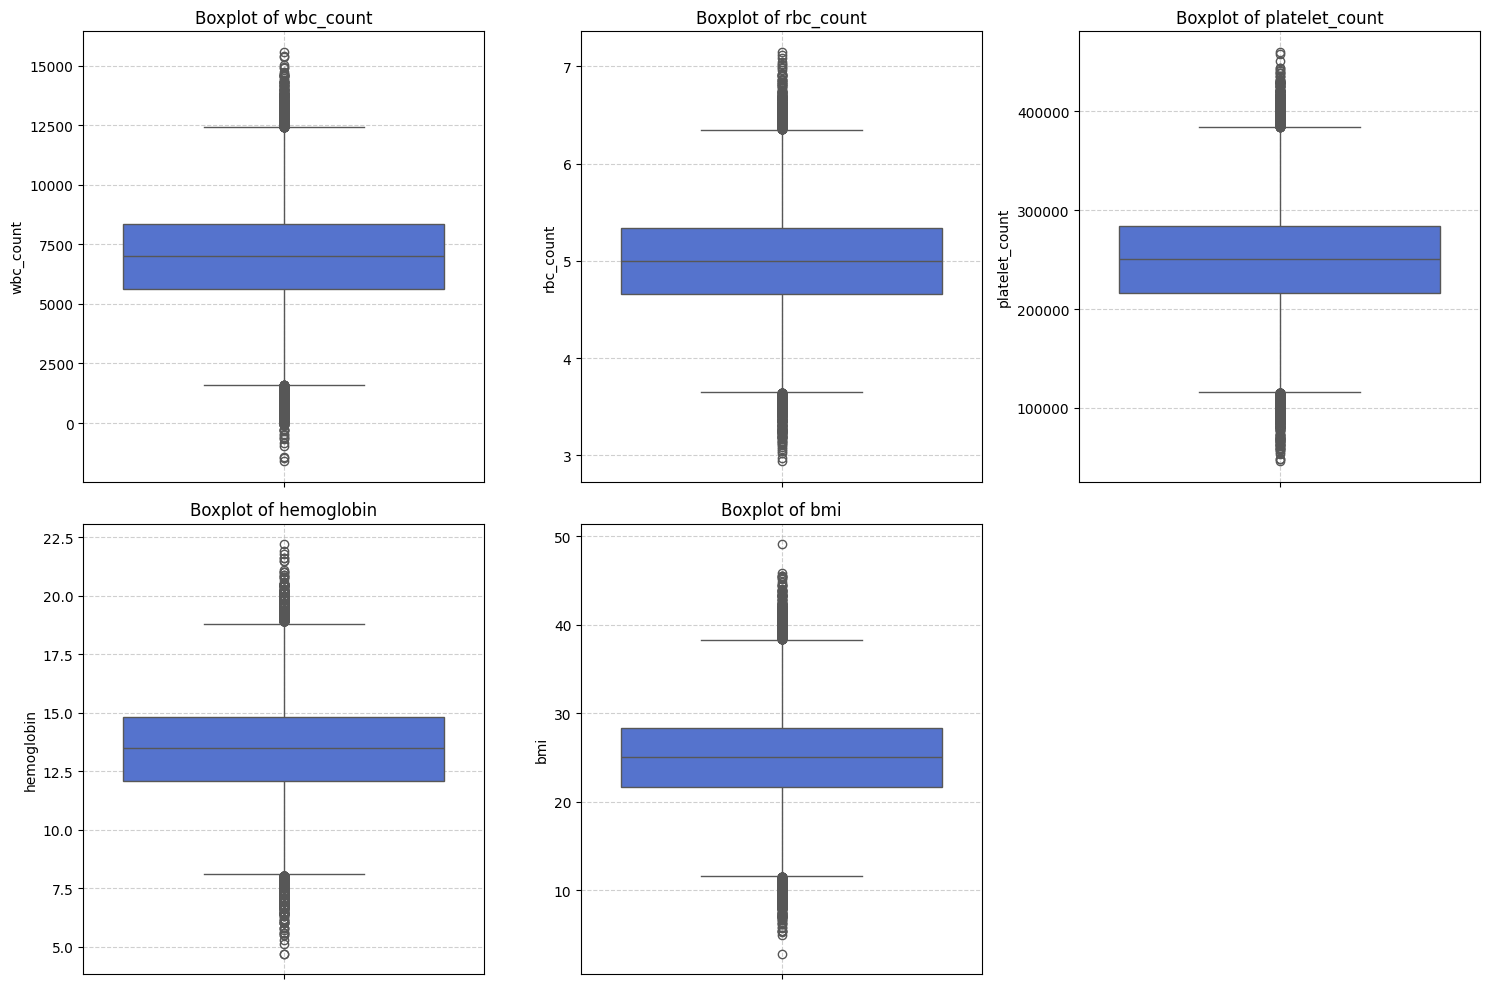

In [ ]:
num_vars = len(numerical_vars)
rows = (num_vars // 3) + (num_vars % 3 > 0)

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten() 
for i, var in enumerate(numerical_vars):
    sns.boxplot(y=df[var], ax=axes[i], color="royalblue")
    axes[i].set_title(f"Boxplot of {var}")
    axes[i].set_ylabel(var)
    axes[i].grid(True, linestyle="--", alpha=0.6)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

The chart displays boxplots for five numerical variables (*wbc_count*, *rbc_count*, *platelet_count*, *hemoglobin_level*, and *bmi*), allowing for an analysis of data distribution, the presence of outliers, and the dispersion of each variable.

Overall, all variables exhibit outliers, which can be crucial for medical data analysis, as these values may indicate specific clinical conditions. Due to the nature of the data, the number of outliers is expected since we are evaluating healthy individuals, individuals with leukemia, and individuals with other pathologies.

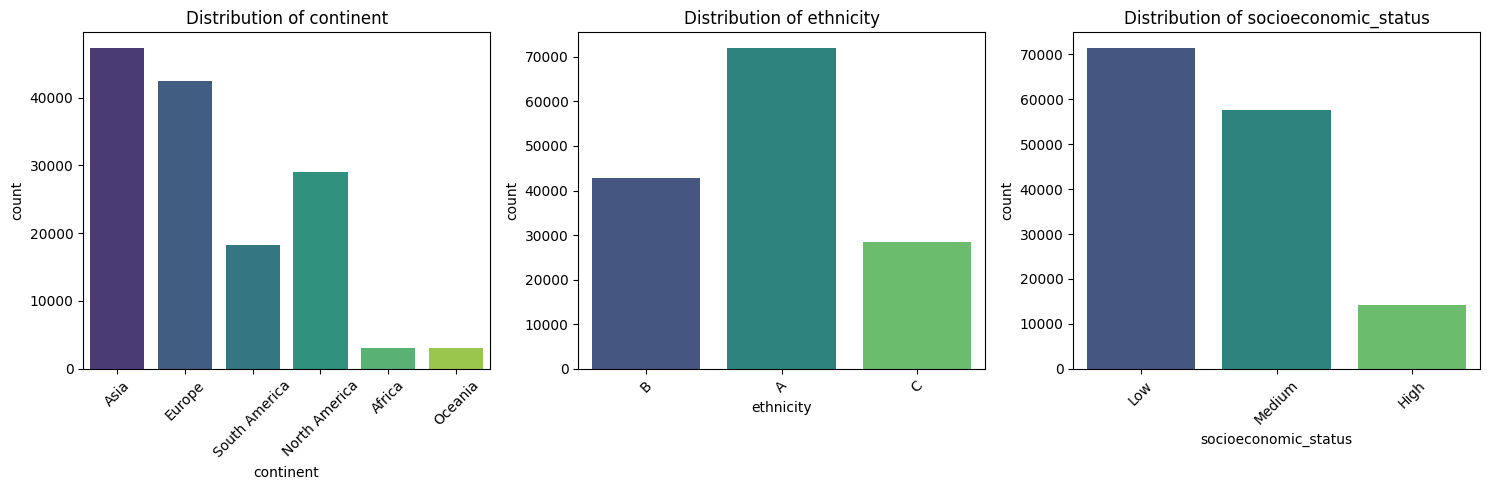

In [ ]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(["continent", "ethnicity", "socioeconomic_status"], 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=df[col], hue=df[col], palette="viridis", legend=False)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The histograms represent the distribution of three categorical variables:

 The dataset is predominantly composed of individuals from Asia and Europe, with lower representation from other continents.<br>
Ethnic group "A" is the most represented, followed by "B" and "C." <br>
The majority of individuals belong to the "Low" and "Medium" socioeconomic classes, with fewer in the "High" category. <br>



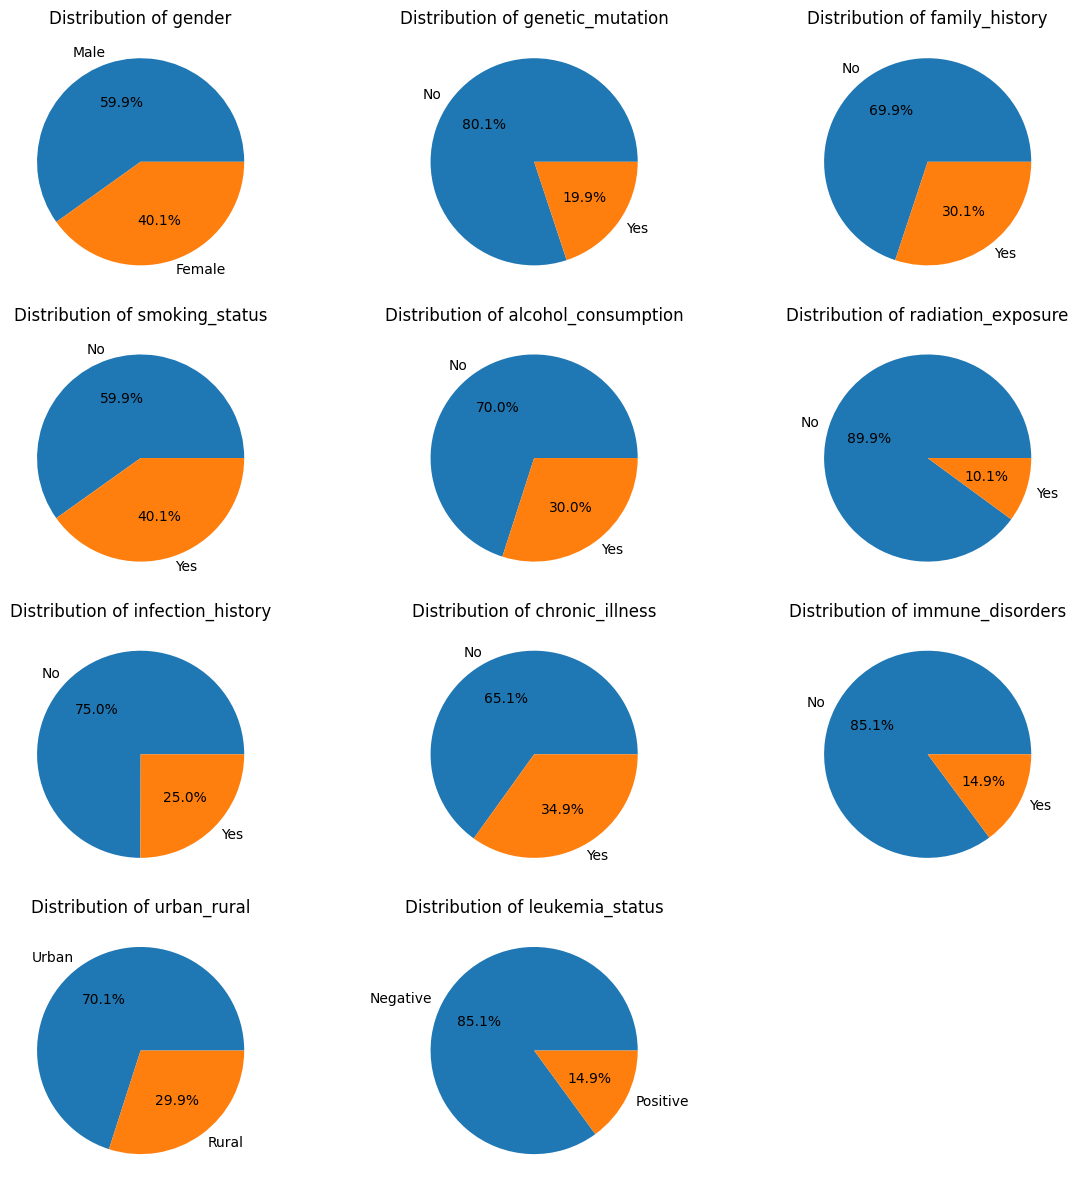

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))  
variables = ["gender", "genetic_mutation", "family_history", "smoking_status", "alcohol_consumption",
             "radiation_exposure", "infection_history", "chronic_illness", "immune_disorders",
             "urban_rural", "leukemia_status"]
for ax, var in zip(axes.flat, variables):
    df[var].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax)
    ax.set_title(f"Distribution of {var}")
    ax.set_ylabel("")  
fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


The pie charts illustrate the distribution of various categorical variables within the dataset. Below are key observations:

The dataset consists of a higher proportion of males (59.9%) compared to females (40.1%). The majority of individuals (80.1%) do not have a known genetic mutation, while 19.9% do. A significant portion (69.9%) of individuals do not have a family history of the condition, whereas 30.1% do. Regarding smoking status, 59.9% of individuals are non-smokers, while 40.1% report smoking. In terms of alcohol consumption, 70.0% do not consume alcohol, whereas 30.0% do. Most individuals (89.9%) have not been exposed to radiation, with only 10.1% reporting exposure. A history of infections is present in 25.0% of the individuals, while 75.0% do not report such history. About 34.9% of individuals have a chronic illness, whereas 65.1% do not. Similarly, 85.1% do not have immune disorders, while 14.9% do. The dataset indicates that 70.0% of individuals live in urban areas, while 30.0% reside in rural areas. Finally, the vast majority (85.1%) of individuals do not have leukemia, whereas 14.9% have been diagnosed with it.

- The prevalence of **genetic mutations, family history, radiation exposure, infection history, chronic illness, and immune disorders** suggests that these factors may play a role in health conditions under study.
- The **higher proportion of urban residents** could indicate a possible link between environmental factors and health risks.
- The **lower prevalence of leukemia (14.9%)** suggests it is a less frequent outcome, but the contributing factors should be analyzed further.



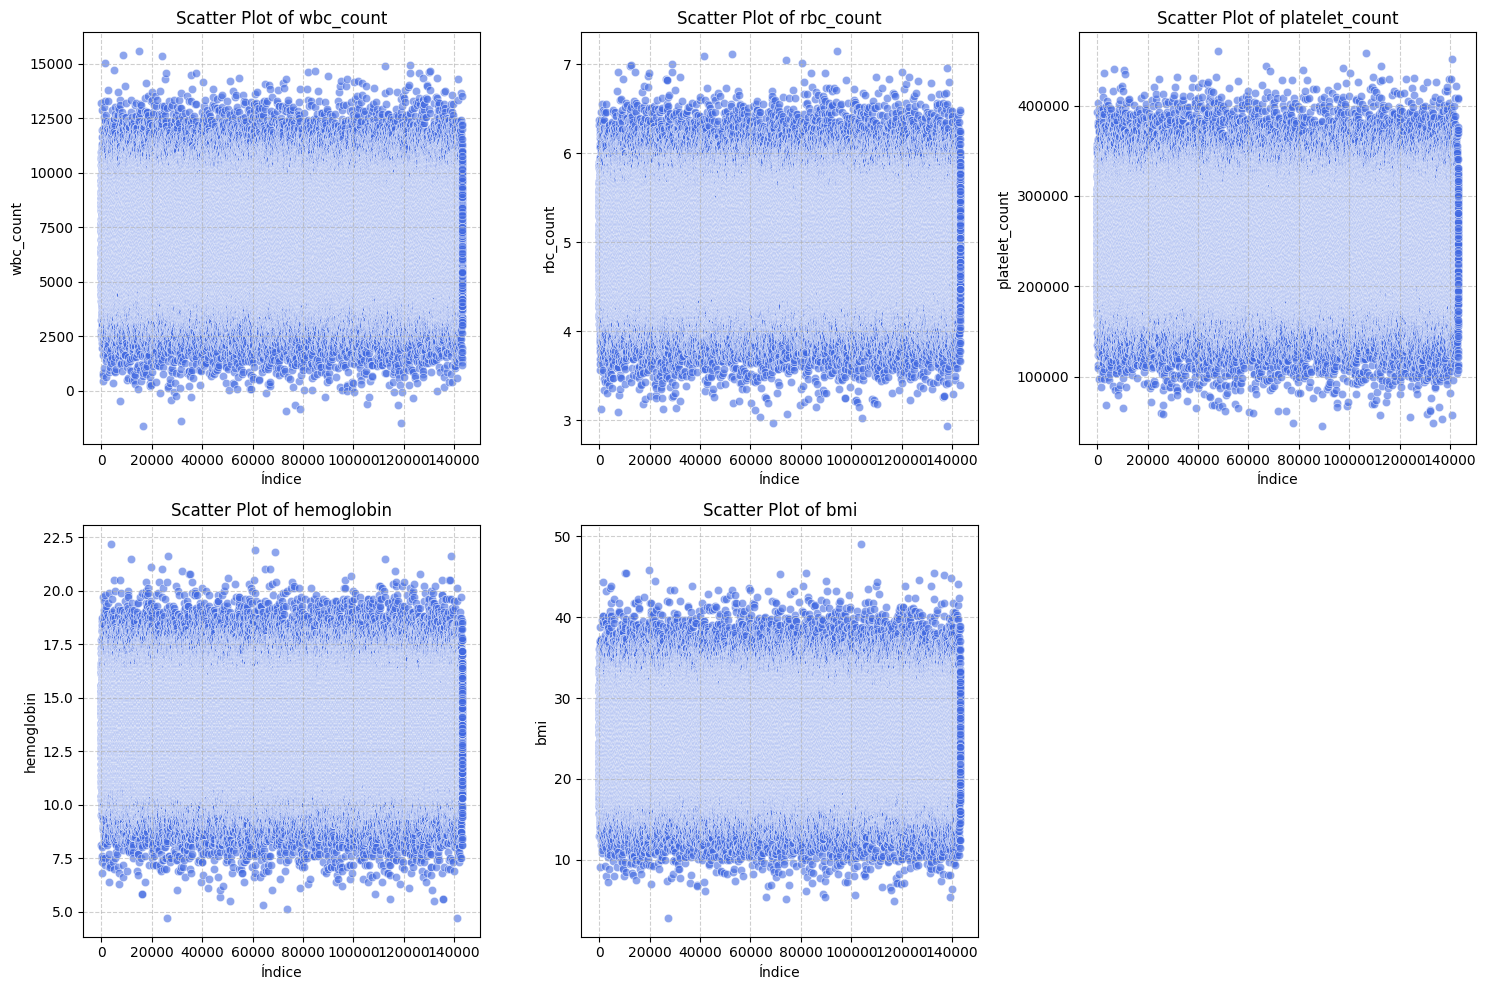

In [ ]:
num_vars = len(numerical_vars)

rows = (num_vars // 3) + (num_vars % 3 > 0)

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    mean = df[var].mean()
    std_dev = df[var].std()
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    sns.scatterplot(x=df.index, y=df[var], ax=axes[i], color="royalblue", alpha=0.6)
    plt.axhline(mean, color='green', linestyle='--', label="Media")
    plt.axhline(lower_bound, color='red', linestyle='--', label="-3 Desv. Est.")
    plt.axhline(upper_bound, color='red', linestyle='--', label="+3 Desv. Est.")
    axes[i].set_title(f"Scatter Plot of {var}")
    axes[i].set_xlabel("Índice")
    axes[i].set_ylabel(var)
    axes[i].grid(True, linestyle="--", alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The scatter plots reveal high variability across all analyzed variables, including white blood cell count (WBC), red blood cell count (RBC), platelet count, hemoglobin levels, and body mass index (BMI). While most values fall within a reasonable range, the presence of outliers is evident in all plots, suggesting that the data does not follow a perfectly normal distribution. These outliers, which are medically valid, reflect extreme conditions commonly seen in leukemia patients, such as leukocytosis, severe anemia, or malnutrition. The wide dispersion observed in the data underscores the importance of considering the full range of values in the analysis, without discarding the extremes, as they provide relevant insights into the clinical heterogeneity of the disease and may influence prognosis and treatment response.

In [ ]:
print(df.columns.tolist())

['id', 'age', 'gender', 'wbc_count', 'rbc_count', 'platelet_count', 'hemoglobin', 'bone_marrow_blasts', 'genetic_mutation', 'family_history', 'smoking_status', 'alcohol_consumption', 'radiation_exposure', 'infection_history', 'bmi', 'chronic_illness', 'immune_disorders', 'ethnicity', 'socioeconomic_status', 'urban_rural', 'leukemia_status', 'continent']


Create the new table with the clean data

In [ ]:
with open('credentials.json', 'r') as file:
    credentials = json.load(file)

engine = create_engine(f"postgresql://{credentials['user']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['dbname']}")

conn = psycopg2.connect(
    dbname=credentials['dbname'],
    user=credentials['user'],
    password=credentials['password'],
    host=credentials['host'],
    port=credentials['port']
)

cur = conn.cursor()

cur.execute("""
CREATE TABLE leukemia_clean_data (
    id SERIAL PRIMARY KEY,
    age INTEGER NOT NULL,
    gender VARCHAR(10) NOT NULL,
    continent VARCHAR(100) NOT NULL,
    wbc_count INTEGER NOT NULL,
    rbc_count NUMERIC(5,2) NOT NULL,
    platelet_count INTEGER NOT NULL,
    hemoglobin NUMERIC(5,2) NOT NULL,
    bone_marrow_blasts INTEGER NOT NULL,
    genetic_mutation VARCHAR(3) CHECK (genetic_mutation IN ('Yes', 'No')),
    family_history VARCHAR(3) CHECK (family_history IN ('Yes', 'No')),
    smoking_status VARCHAR(50),
    alcohol_consumption VARCHAR(3) CHECK (alcohol_consumption IN ('Yes', 'No')),
    radiation_exposure VARCHAR(3) CHECK (radiation_exposure IN ('Yes', 'No')),
    infection_history VARCHAR(3) CHECK (infection_history IN ('Yes', 'No')),
    bmi NUMERIC(5,2) NOT NULL,
    chronic_illness VARCHAR(3) CHECK (chronic_illness IN ('Yes', 'No')),
    immune_disorders VARCHAR(3) CHECK (immune_disorders IN ('Yes', 'No'))
);
""")


conn.commit()


DuplicateTable: la relación «leukemia_clean_data» ya existe


Debido a que ethnicity no aprta informacion relevante para el analisis, se procede a eliminar la columna.

In [52]:
df.drop("ethnicity")

KeyError: "['ethnicity'] not found in axis"

##### Charge the new dataset in a table leukemia_clean_data

In [53]:
df.to_sql("leukemia_clean_data", con=engine, if_exists="replace", index=False)

76

Now, close the connection

In [ ]:
cur.close()
conn.close()